In [5]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from google.cloud import storage

import sys
import importlib

def call_module(nm, path):
    spec = importlib.util.spec_from_file_location(nm, path)
    foo = importlib.util.module_from_spec(spec)
    sys.modules[nm] = foo
    spec.loader.exec_module(foo)
    return foo

In [6]:
def download_files_from_folder(bucket_name, bucket_fd, local_fd, files):
    """Download all files from a folder in a Google Cloud Storage bucket."""
    # Initialize a client
    client = storage.Client()
    # Get the bucket
    bucket = client.bucket(bucket_name)
    # List all blobs (files) in the specified folder
    for file in files:
        blob = bucket.blob(f"{bucket_fd}/{file}")
        blob.download_to_filename(f"{local_fd}/{file}")

In [7]:
model_type = 'letterstrip_fontdiffuser_training_phase_1'
model_i = '430000'
files_dict = {
    'unet': f"{model_type}__unet_{model_i}.pth",
    'content_encoder': f"{model_type}__content_encoder_{model_i}.pth",
    'style_encoder': f"{model_type}__style_encoder_{model_i}.pth",
}
local_fd = "/home/jupyter/ai_font/data/model"
os.makedirs(local_fd, exist_ok=True)
download_files_from_folder("leo_font","experiments",local_fd,list(files_dict.values()))

In [8]:
fd = "/home/jupyter/ai_font/experiments/sample"
module_fd = "/home/jupyter/ai_font/experiments/font_diffuser_letterstrip"
args = call_module('args', f"{fd}/args.py")
SampleArgs = args.SampleArgs

sample = call_module('sample', f"{fd}/sample.py")
load_fontdiffuser_pipeline = sample.load_fontdiffuser_pipeline
sampling = sample.sampling

In [9]:
args = SampleArgs()
modelpaths = {k:f"{local_fd}/{v}" for k,v in files_dict.items()}

In [10]:
pipe = load_fontdiffuser_pipeline(args, module_fd, modelpaths)

Load the down block  DownBlock2D
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  DownBlock2D
Load the up block  UpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  UpBlock2D
Param count for Ds initialized parameters: 20591296
Get CG-GAN Style Encoder!
Param count for Ds initialized parameters: 1187008
Get CG-GAN Content Encoder!
Loaded the model state_dict successfully!
Loaded training DDPM scheduler sucessfully!
Loaded dpm_solver pipeline sucessfully!


In [11]:
# 글자와 언신 스타일을 섞어서 다 찍어내기
savefd = "/home/jupyter/ai_font/data/report"
os.makedirs(savefd, exist_ok=True)

In [ ]:
itercount = 0
for font in args.test_fonts:
    styles = [int(f.split("__")[-1].replace(".png","")) for f in os.listdir(f"{args.data_fd}/seen/") if font in f][:100]
    for c in args.seens_ids:
        for s in styles:
            if c != s:
                savepath = f"{savefd}/{model_type}__{font}__seen__c{c}_s{s}.png"
                img = sampling(
                    args=args, 
                    pipe=pipe, 
                    content_image=Image.open(f"{args.data_fd}/seen/gulim__{c}.png").convert("RGB"),
                    style_image=Image.open(f"{args.data_fd}/seen/{font}__{s}.png").convert("RGB"),
                    verbose = False,
                            )
                img.save(savepath)
                itercount += 1
                print(itercount, "seen", end="\r")
    for c in args.unseens_ids:
        for s in styles:
            if c != s:
                savepath = f"{savefd}/{model_type}__{font}__unseen__c{c}_s{s}.png"
                img = sampling(
                    args=args, 
                    pipe=pipe, 
                    content_image=Image.open(f"{args.data_fd}/seen/gulim__{c}.png").convert("RGB"),
                    style_image=Image.open(f"{args.data_fd}/seen/{font}__{s}.png").convert("RGB"),
                    verbose = False,
                            )
                img.save(savepath)
                itercount += 1
                print(itercount, "unseen", end="\r")

/home/jupyter/ai_font/experiments/font_diffuser_letterstrip/model.py:89: FutureWarning: Accessing config attribute `style_encoder` directly via 'FontDiffuserModelDPM' object attribute is deprecated. Please access 'style_encoder' over 'FontDiffuserModelDPM's config object instead, e.g. 'unet.config.style_encoder'.
  style_img_feature, _, style_residual_features = self.style_encoder(style_images)
/home/jupyter/ai_font/experiments/font_diffuser_letterstrip/model.py:95: FutureWarning: Accessing config attribute `content_encoder` directly via 'FontDiffuserModelDPM' object attribute is deprecated. Please access 'content_encoder' over 'FontDiffuserModelDPM's config object instead, e.g. 'unet.config.content_encoder'.
  content_img_feture, content_residual_features = self.content_encoder(content_images)
/home/jupyter/ai_font/experiments/font_diffuser_letterstrip/model.py:98: FutureWarning: Accessing config attribute `content_encoder` directly via 'FontDiffuserModelDPM' object attribute is depre

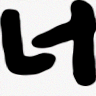

In [25]:
Image.open([f"{savefd}/{f}" for f in os.listdir(savefd) if model_type in f][13])